In [4]:
import numpy as np
import jax.numpy as jp
from scipy import sparse
import copy

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook 

from jax import random
from jax.experimental import stax,optimizers
from jax.experimental.stax import Dense
from jax import grad, value_and_grad, vmap
from jax.nn.initializers import he_uniform, glorot_normal
from jax.experimental.stax import Dense, Relu, LeakyRelu, Elu, Dropout, Gelu, Sigmoid

In [5]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
##interaction_matrix = np.array(interaction_matrix.todense())
#
interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')
##interaction_dates = np.array(interaction_dates.todense())

In [6]:
year=2010
#turn interaction dates into a masker
dates_mask = (interaction_dates.data<=year).astype(int)


#make copies that will become train / test matrices
train = copy.copy(interaction_matrix)
test = copy.copy(interaction_matrix)

#remove 2015 and later records from train matrix
train.data = train.data * dates_mask
#remove all training data from the test matrix.
test.data = test.data - train.data

#remove any rows from the train matrix that have zero interactions.
#this is the case any time a new ligand is discovered in the cutoff-year or after.
#we can't use link prediction on new ligands! It's a cold start problem.
#so we remove all these ligands from the present analysis.
row_mask = np.array((train.sum(axis=1)!=0)).reshape(1,-1)[0] #there must be a cleaner way to do that.
train = train[row_mask]
test = test[row_mask]

train.eliminate_zeros()
test.eliminate_zeros()

In [1]:
def init_my_network():
    test_rng = random.PRNGKey(1)
    _, dec_init_rng = random.split(random.PRNGKey(2))
    ##got median down to about 15 or 16 using glorot_normal and no activations. 3x243.
    #and that had adam optimizer with step_size=1e-4. 
    #243, 125, 243 also works pretty good, with glorot_normal.
    decoder_init, decode = stax.serial(
        Dense(243, W_init=glorot_normal()), 
        #Dense(125, W_init=glorot_normal()), 
        #Dense(243, W_init=glorot_normal()),
        #Dense(243, W_init=glorot_normal()),
        Dense(243, W_init=glorot_normal()),
        Dense(243, W_init=glorot_normal()),
        Sigmoid)

    _, init_decoder_params =decoder_init(dec_init_rng, (-1,243))
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
    #opt_init, opt_update, get_params = optimizers.adagrad(step_size=1e-3)
    opt_state = opt_init(init_decoder_params)
    return opt_state, opt_update, decode, get_params

def compare_ranks(score, lab):
    return (jp.log(1+jp.exp(score-score[:,jp.newaxis]))*lab).sum()


def loss(p, label_vector):
    scores = decode(p,label_vector)
    #label_mask = label_vector.astype(bool)
    #scores_pos = scores[label_mask]
    #scores_neg = scores[~label_mask]
    #cores_diff = scores_neg-scores_pos[:,jp.newaxis]
    
    return - vmap(compare_ranks, in_axes=(0,0))(scores, label_vector).sum()


def step(i, opt_state):
    p = get_params(opt_state)  
    #a random input:
    label_vector = mymat[np.random.choice(np.arange(mymat.shape[0]), 200, replace=False)]
    l, g = value_and_grad(loss)(p, label_vector)
    
    if i%10==0:
        loss_list.append(l)
        print(l)
    #if i%10==0:
    #    print('PRINTING RESULT ON TEST:')
        #preds = decode(p, train.toarray())
        #ranks = evaluate_predictions(preds, test, train )
        #ranks_median_list.append(np.median(ranks))
        #ranks_mean_list.append(np.mean(ranks))
        #print(np.median(ranks), np.mean(ranks))
        #doplot(ranks_median_list, ranks_mean_list)
        
    return opt_update(i, g, opt_state)

def doplot(medians, means):
    fig,ax=plt.subplots()
    ax.plot(medians, label='medians')
    ax.plot(means, label='means')
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(10,150)
    ax.set_yticks([10,20,30,40,50,60,70,80,90,100,150])
    fig.savefig('progress.png')
    plt.close()
    return None
    

In [8]:
mymat = train.toarray()#interaction_matrix.toarray()

row_mask = mymat.sum(axis=1)>1

mymat = mymat[row_mask]

In [9]:
loss_list = list()
ranks_median_list = list()
ranks_mean_list = list()
opt_state, opt_update, decode, get_params = init_my_network()



for i in tqdm_notebook(range(2860)):
    opt_state = step(i, opt_state)


/Users/lmar3213/miniconda3/envs/lew_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
<ipython-input-9-549bd4ca5898>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(2860)):


-96503.32
-89295.11
-108139.78
-92888.516
-104890.195
-106273.195
-107995.76
-100372.08
-102821.23
-108879.586
-103228.68
-101996.086
-108913.74
-110145.81
-107947.48
-108085.87
-109043.08
-118570.266
-131095.6
-131810.52
-128538.71
-129122.39
-119442.17
-140292.92
-131925.34
-137884.39
-142146.19
-151242.98
-141330.97
-148331.03
-144481.55
-143211.45
-144792.97
-140190.81
-157402.84
-135990.7
-148655.94
-147690.86
-154587.38
-143341.4
-141532.97
-147982.14
-172250.25
-155055.66
-147987.78
-159168.67
-153725.1
-147003.78
-143998.38
-161767.72
-171117.66
-140506.48
-154647.34
-162389.19
-150162.03
-167295.6
-174159.3
-149419.9
-154020.23
-149884.89
-165954.05
-148494.97
-168574.94
-152176.7
-159063.66
-152620.77
-158244.97
-156753.22
-163635.62
-160699.27
-163590.64
-144586.73
-161819.98
-157393.31
-171754.98
-171053.72
-164082.81
-157257.88
-182222.42
-164117.64
-157034.78
-168405.03
-165771.47
-152195.97
-166845.16
-168804.05
-174844.78
-167918.83
-165011.44
-153368.92
-174363.42
-171

In [10]:
from scipy.stats.mstats import rankdata
def evaluate_predictions(predictions, test, train):
    """
    Input a numpy array, with rows for instances and columns for labels,
    with entries containing predicted interaction scores. Usually, the higher
    the highest interaction score corresponds to the top predicted ligand,
    and thus function assumes the most positive score is the best.

    Calculates the ranks of the test ligands and returns the mean rank.
    This is to be optimized (i.e. minimized) by scikit-optimize.

    :param prediction_matrix: n by m np array (n = number of instances, m = number of labels)
    containg predicted interaction scores resulting from some recommender algorithm
    :param test: n by m sparse matrix containing 1's in the positions of each test label. Returned
    by train_test_split.
#    :param outtype: either 'mean', 'unbiased_mean', or 'full'. Mean gives the mean over
#    all ranks for each test label. Unbiased mean accounts for inspection bias (where promiscuous
#    ligands are over-represented in the mean statistic) by first taking the mean rank for EACH
#    ligand, and then taking mean over all these. 'Full' just returns the ranks of all ligands.
    """
    if isinstance(test, sparse.csr_matrix):
        test = test.toarray()
    if isinstance(train, sparse.csr_matrix):
        train = train.toarray()
    if isinstance(predictions, sparse.csr_matrix):
        predictions = predictions.toarray()
        
    #This will mask all ROWS that contain no test ligands. No point ranking
    #a row if you're aren't going to evaluate the ranks!
    #(and it works on sparse or np.array)
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool) #this will select using boolean all test ranks.

    ####Double argsort approach (not used anymore):
    ##order from highest to lowest:
    #order = (-prediction_matrix).argsort(axis=1)
    ##get ranks of each ligand.
    #ranks = order.argsort(axis=1)

    #This step masks the known positives from the training set,
    #so we are not penalising a highly ranked unknown if it
    #is only behind other true positives. This has a pretty substantial
    #effect since the algo's are really good at ranking known positives highly.
    predictions = np.ma.masked_array(predictions[row_mask], mask=train[row_mask].astype(bool))
    #rankdata approach, which correctly handles ties and also thankgod can take masked arrays:
    prediction_ranks = rankdata(-predictions, axis=1)

    #all ranks:
    all_test_ranks = prediction_ranks[get_ranks]
    return all_test_ranks

In [11]:
p = get_params(opt_state)  
preds = decode(p, train.toarray())
ranks = evaluate_predictions(preds, test, train )

In [23]:
np.save('jax-ranks.npy', ranks)

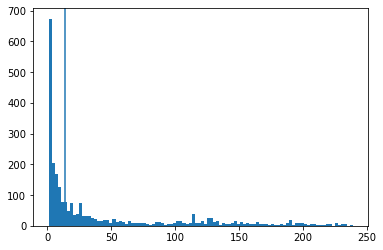

In [16]:
_=plt.hist(ranks,bins=100)
plt.axvline(14)

In [ ]:
plt.plot(ranks_median_list)
plt.plot(ranks_mean_list)
plt.axvline(np.argmin(ranks_mean_list))
plt.axvline(np.argmin(ranks_median_list))
plt.yscale('log')

In [ ]:
for i in range(len(ranks_mean_list)):
    if ranks_mean_list[i+1] > ranks_mean_list[i]:
        print(i)

In [ ]:
np.argmin(ranks_median_list)

In [ ]:
plt.plot(ranks_median_list, ranks_mean_list)
plt.ylim(40,60)
plt.xlim(0,30)

In [ ]:
plt.plot(loss_list)
#plt.yscale('log')

In [ ]:
p = get_params(opt_state)

label_vector = mymat[np.random.choice(np.arange(mymat.shape[0]), 10, replace=False)]


#scores = jp.log(decode(p,label_vector))
#l, g = value_and_grad(loss)(p, label_vector)


In [ ]:
preds = decode(p, train.toarray())

In [ ]:

_=plt.hist(evaluate_predictions(preds, test, train ),bins=100)

In [ ]:
np.median(evaluate_predictions(preds, test, train ))

In [ ]:
boop[88]

In [ ]:
scores[0]*(1-label_vector[0])

In [ ]:
raw

In [ ]:
scores = np.log(raw)
scores

In [ ]:
vmap(compare_ranks, in_axes=(0,0))(scores, label_vector)

In [ ]:
compare_ranks(scores[0], label_vector[0])

In [ ]:
def compare_ranks(score, lab):
    return (jp.log(1+jp.exp(score-score[:,jp.newaxis]))*lab).sum()
    
    #score_pos = score*lab
    #score_neg = score*(1-lab)
    #score_diff = score_pos[:,jp.newaxis] - score_neg
    return score_diff


In [ ]:
vmap(compare_ranks,in_axes=(0,0))(scores, label_vector.astype(bool))

In [ ]:
label_vector.astype(bool)

In [ ]:
plt.imshow(jp.log(1+jp.exp(score-score[:,jp.newaxis])) * lab)

In [ ]:
plt.imshow(score_pos[:,jp.newaxis] - score)

In [ ]:
compare_ranks(scores[0], mymat[2])

In [ ]:
vmapped = vmap(compare_ranks, in_axes=(0,0))

vmapped(scores, label_vector)

In [ ]:
scores.shape

In [ ]:
jp.array(label_vector)

In [ ]:
scores = jp.log(decode(p,label_vector))
label_mask = label_vector.astype(bool)
scores_pos = scores[label_mask]
scores_neg = scores[~label_mask]
    
scores_diff = scores_neg-scores_pos[:,jp.newaxis]

In [ ]:
scores.shape

In [ ]:
scores[label_mask]

In [ ]:
np.sum(label_mask)

In [ ]:
label_vector[0].nonzero()

In [ ]:
scores[0][232]

In [ ]:
p = get_params(opt_state)

In [ ]:
mymat = interaction_matrix.toarray()

In [ ]:
np.random.choice(np.arange(243))